Implementing Neural Networks from scratch without using Tensorflow
<br><br>
The MNIST data set consists of 70,000 images of handwritten digits. It consists of digits from 0 to 9, the requirement is to classify the class to which the image belongs. The images in the MNIST data set are 28X28 pixels, and the input layer shall have 784 neurons (each neuron takes 1 pixel as the input). The output layer shall have 10 neurons, with each giving the probability of the input image belonging to any of the 10 classes. The image is classified into the class that is represented by the neuron with the highest probability. In the diagram below, you can see a few sample images that are available in the dataset.
<br><br>


<img src="https://images.upgrad.com/80bd8b72-de1d-4ea6-9923-6b9fc3d03ed9-8.png">


In [1]:
# Import required libraries:
# For model file handling
import pickle
import gzip

import numpy as np
import pandas as pd
import h5py

import sklearn
import sklearn.datasets
import scipy

# For plotting and image displays
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
%matplotlib inline

# Download Dataset

In [2]:
data_url = "https://cdn.upgrad.com/uploads/production/2f798b87-a95d-4d53-b34b-166f291c022b/mnist.pkl.gz"
# Download the dataset to the local path
!wget $data_url
!ls

--2022-06-16 04:35:48--  https://cdn.upgrad.com/uploads/production/2f798b87-a95d-4d53-b34b-166f291c022b/mnist.pkl.gz
Resolving cdn.upgrad.com (cdn.upgrad.com)... 54.192.81.121, 54.192.81.35, 54.192.81.105, ...
Connecting to cdn.upgrad.com (cdn.upgrad.com)|54.192.81.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17051982 (16M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  16.26M  28.7MB/s    in 0.6s    

2022-06-16 04:35:49 (28.7 MB/s) - ‘mnist.pkl.gz’ saved [17051982/17051982]

mnist.pkl.gz  sample_data


# Load Dataset
* uncompress the dataset file
* read the file into python variables

In [3]:
def load_data(file='mnist.pkl.gz'):
  """
  Function to uncompress .gz file into a .pkl file. Load the .pkl file as 
  train_data, validation_data and test_data in that order
  file: string, .gz filename containing .pkl dataset file
  """
  # Open the file in read-only binary mode using gzip library
  file_pointer = gzip.open(file, mode='rb')
  # point the file_pointer to the start of the file
  file_pointer.seek(0)
  # load the three dataset objects
  # The data was created using latin1 encoding
  train_data, validation_data, test_data = pickle.load(file_pointer,
                                                       encoding='latin1')
  return train_data, validation_data, test_data

In [4]:
train, val, test = load_data()
print(f'train data type = {type(train)}, len = {len(train)}')
print(f'val data type = {type(val)}, len = {len(val)}')
print(f'test data type = {type(test)}, len = {len(test)}')

train data type = <class 'tuple'>, len = 2
val data type = <class 'tuple'>, len = 2
test data type = <class 'tuple'>, len = 2


In [12]:
print(f'Dimensions of train data,\n train [0] type = {type(train[0])},\
 shape = {train[0].shape}\n train[1] type ={type(train[1])},\
 shape= {train[1].shape}')
print('Sample of target values in train data = ', train[1][:5])

Dimensions of train data,
 train [0] type = <class 'numpy.ndarray'>, shape = (50000, 784)
 train[1] type =<class 'numpy.ndarray'>, shape= (50000,)
Sample of target values in train data =  [5 0 4 1 9]


There are 50k images each of dimension 28x28 (=784) and 50k targets. We want the image data to be of the form (784, 50000). This can be done by a simple transpose.

The targets have to be in a onehot encoded form. A separate function will be written to peerform this operation.

In [19]:
#One Hot Encoder for the targets
def one_hot(labels):
  """
  Function to convert input 1 dim labels into 2 dim one-hot encoded labels
  labels: (n,) numpy array
  Returns (n, f) numpy array, where f + 1 = number of unique values in labels
  """
  encoder = sklearn.preprocessing.OneHotEncoder()
  return encoder.fit_transform(labels.reshape(-1,1)).todense()
  
# Testing one_hot function
one_hot(np.array(range(0,11)))

matrix([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [21]:
# Making train_data of the shape 784,50_000
train_data = train[0].T
# Getting the one hot encoded training labels
train_label = one_hot(train[1])

# Performing the same operations for the test data and validation data
test_data = test[0].T
test_label=one_hot(test[1])

val_data = val[0].T
val_label = one_hot(val[1])

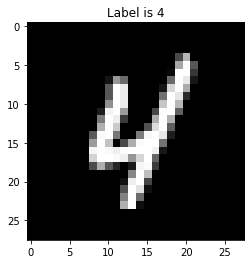

In [25]:
# Checking a sample image
index= 166
img = train_data[:,index].reshape((28,28))
plt.title('Label is '+ str(train[1][index]))
plt.imshow(img, cmap='gray')

# FeedForward Network

In [28]:
def sigmoid(z):
  """
  Function to compute the sigmoid activation function of the cumulative input z
  """
  h = 1/(1 + np.exp(-z))
  # Storing the values of z for backpropagation
  sigmoid_memory = z
  return h, sigmoid_memory

# Testing the sigmoid function
sigmoid(np.arange(8).reshape(4,2))

(array([[0.5       , 0.73105858],
        [0.88079708, 0.95257413],
        [0.98201379, 0.99330715],
        [0.99752738, 0.99908895]]), array([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7]]))

In [30]:
def relu(z):
  """
  Function to compute the ReLu activation function
  Returns 
  h: output after applicatioin of the activation function
  relu_memory: Same as the input
  """
  h = np.maximum(0,z)
  assert(h.shape == z.shape)
  relu_memory = z
  return h, relu_memory

#Testing the relu function
relu(np.arange(-4, 4).reshape(-1,2))

(array([[0, 0],
        [0, 0],
        [0, 1],
        [2, 3]]), array([[-4, -3],
        [-2, -1],
        [ 0,  1],
        [ 2,  3]]))

In [37]:
def softmax(z):
  """
  Function to compute the softmax activation function
  """
  h = np.exp(z)/np.sum(np.exp(z), axis=0, keepdims=True)

  softmax_memory = z
  return h, softmax_memory

#Testing the softmax function
softmax(np.random.random_sample((3,2)))

(array([[0.33680971, 0.38351906],
        [0.33393935, 0.38474052],
        [0.32925094, 0.23174042]]), array([[0.17534881, 0.52623496],
        [0.16679012, 0.52941477],
        [0.15265091, 0.02246349]]))

# Initialize Parameters

Create a dictionary of weights and biases. Weights shall be initialized randomly and biases shall be initialized at zero

In [40]:
def initialize_params(layer_config):
  """
  Function to initialize weights and biases of the Feedforward network
  layer_config = list containing the length of layer. the list should include 
    the length of the input and output layers.
    For hidden layers, the value would be the number of neurons. 
    For input layer, this would be the length of the input dimension. 
    For output layer, it would be the number of classes at the output
  Returns:
  dict: Keys would be  W1, W2 ... Wn for weights, b1, b2,... bn for biases
      Values would be the corresponding weights and biases
  """
  params = {}
  number_of_layers = len(layer_config)
  for l in range(1, number_of_layers):
    # Create random weights with scaling of 0.1
    params["W" + str(l)] = np.random.randn(layer_config[l], 
                                           layer_config[l-1]) * 0.1
    params['b' + str(l)] = np.zeros((layer_config[l],1))

    assert(params['W' + str(l)].shape == (layer_config[l],layer_config[l-1]))
    assert(params['b' + str(l)].shape == (layer_config[l],1))
  return params

In [42]:
# Testing the initialize_param function
params = initialize_params([784, 7, 3, 5, 10])
params.keys()

dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4'])

In [44]:
params['W1']

array([[ 0.09569212, -0.02235143,  0.18484731, ..., -0.0560824 ,
        -0.06189288, -0.072475  ],
       [-0.04323618,  0.11994046, -0.02544718, ..., -0.12853196,
         0.08377511,  0.03346023],
       [ 0.19019729, -0.211491  ,  0.03335938, ...,  0.05233743,
         0.14310686, -0.0578032 ],
       ...,
       [-0.10018275, -0.17399205,  0.03897183, ..., -0.05983332,
         0.26783265,  0.06479174],
       [ 0.04748795,  0.10624506,  0.10151084, ...,  0.20304851,
         0.01810277,  0.07137117],
       [ 0.08531997, -0.04249314, -0.14588307, ...,  0.00479644,
         0.05644999, -0.10865577]])

In [45]:
params['b1']

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [47]:
def layer_forward(h_prev, w, b, activation='relu'):
  """
  Function to calculate cumulative input and apply activation function to it
  h_prev: The output from previous layer. For the first layer, this would 
    be same as the input data
  w = weights for the layer
  b = bias for the layer. For now the bias is common to all the neurons in a 
    layer
  activation = the activation functioin to apply. This can be 'relu' or 
    'sigmoid' or 'softmax'
  
  """
  # Store the input in a location
  linear_memory = (h_prev, w, b)
  # calculate the cumulative input to the activation functioin
  z = np.matmul(w, h_prev) + b
  # Apply the activation function
  if activation == 'relu':
    h, activation_memory = relu(z)
  elif activation == 'sigmoid':
    h, activation_memory = sigmoid(z)
  else:
    h, activation_memory = softmax(z)
  return h, linear_memory


In [50]:
# Testing the layer_forward function
# considering that layer l-1 has 2 neurons and layer l has 3 neurons
# h_prev = (2x5), w=(3x2) , b=(3,1)
# h should be 3x5
h_prev = np.array([[2, 3, 4, -5, 6], 
                   [0, 3, -4, 7, -9]
                   ])
w = np.array([[1, 3],
              [2, 6],
              [0, 4]
              ])
b = np.array([[1], [1], [1]])

h = layer_forward(h_prev, w, b )[0]
h

array([[ 3, 13,  0, 17,  0],
       [ 5, 25,  0, 33,  0],
       [ 1, 13,  0, 29,  0]])

In [51]:
def feedforward_network(X, params):
  """
  Function to 
  """
  h = X
  layers = len(params)//2
  memories = []
  # Call the layer_forward function for each layer except the output layer
  for layer in range(1,layers):
    h, memory = layer_forward(h_prev = h,
                              w = params["W" + str(layer)],
                              b = params["b" + str(layer)],
                              activation = 'relu')
    memories.append(memory)
  # Apply softmax for the final output layer
  h, memory = layer_forward(h_prev = h, 
                            w = params["W" + str(layers)],
                            b = params["b" + str(layers)],
                            activation='softmax')
  memories.append(memory)
  return h, memories
  

In [53]:
# Testing the feedforward_netword function 
# randomly select a data sample from the training data 
x_sample = train_data[:,4]

h = feedforward_network(x_sample, params)[0]
print(h.shape)
h

(10, 7)


array([[0.10012259, 0.10003086, 0.1       , 0.1       , 0.1       ,
        0.1       , 0.10020712],
       [0.10003362, 0.10000847, 0.1       , 0.1       , 0.1       ,
        0.1       , 0.10005677],
       [0.09997068, 0.09999262, 0.1       , 0.1       , 0.1       ,
        0.1       , 0.09995046],
       [0.09999903, 0.09999976, 0.1       , 0.1       , 0.1       ,
        0.1       , 0.09999834],
       [0.10004827, 0.10001215, 0.1       , 0.1       , 0.1       ,
        0.1       , 0.10008151],
       [0.10000778, 0.10000196, 0.1       , 0.1       , 0.1       ,
        0.1       , 0.10001313],
       [0.0999308 , 0.09998257, 0.1       , 0.1       , 0.1       ,
        0.1       , 0.09988313],
       [0.10001069, 0.10000269, 0.1       , 0.1       , 0.1       ,
        0.1       , 0.10001803],
       [0.09998329, 0.09999579, 0.1       , 0.1       , 0.1       ,
        0.1       , 0.09997175],
       [0.09989326, 0.09997312, 0.1       , 0.1       , 0.1       ,
        0.1       , 0.0